In [1]:
# # Step 1: Imports, Setup, and Device Configuration
# In this cell, we import all necessary libraries and set up the device.
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import matplotlib.pyplot as plt
# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# Step 2: Define the Attention U-Net Model (T1-only)
# This cell defines an Attention U-Net model, which enhances the standard U-Net by incorporating attention gates to focus on the tumour regions in T1 scans.
class DoubleConv(nn.Module):
    """Applies two successive convolutional layers with batch normalization and ReLU activation."""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class AttentionBlock(nn.Module):
    """
    Attention block for the U-Net. This block receives the gating signal from the decoder
    and the skip connection from the encoder, and outputs a refined feature map.
    """
    def __init__(self, F_g, F_l, F_int):
        """
        F_g: Number of channels in the gating signal (decoder features)
        F_l: Number of channels in the skip connection (encoder features)
        F_int: Number of intermediate channels (for internal computations)
        """
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        """
        g: gating signal from decoder
        x: skip connection from encoder
        """
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        # Multiply attention coefficients with the skip connection features
        return x * psi

class AttentionUNet(nn.Module):
    """
    Attention U-Net for T1-only segmentation.
    Input: single channel T1 slice.
    Output: single channel segmentation (tumour vs background).
    """
    def __init__(self, in_channels=1, out_channels=1):
        super(AttentionUNet, self).__init__()
        
        # Encoder
        self.conv1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)
        
        # Decoder with Attention
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.conv4d = DoubleConv(1024, 512)
        
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.conv3d = DoubleConv(512, 256)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.conv2d = DoubleConv(256, 128)
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.conv1d = DoubleConv(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        
        # Bottleneck
        bn = self.bottleneck(p4)
        
        # Decoder with attention
        u4 = self.up4(bn)
        # Apply attention on skip connection from c4
        att4 = self.att4(g=u4, x=c4)
        cat4 = torch.cat([u4, att4], dim=1)
        c4d = self.conv4d(cat4)
        
        u3 = self.up3(c4d)
        att3 = self.att3(g=u3, x=c3)
        cat3 = torch.cat([u3, att3], dim=1)
        c3d = self.conv3d(cat3)
        
        u2 = self.up2(c3d)
        att2 = self.att2(g=u2, x=c2)
        cat2 = torch.cat([u2, att2], dim=1)
        c2d = self.conv2d(cat2)
        
        u1 = self.up1(c2d)
        att1 = self.att1(g=u1, x=c1)
        cat1 = torch.cat([u1, att1], dim=1)
        c1d = self.conv1d(cat1)
        
        out = self.final_conv(c1d)
        return out

# Instantiate the model and print its summary
model = AttentionUNet(in_channels=1, out_channels=1).to(device)
print(model)


AttentionUNet(
  (conv1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU

In [3]:
#Step 3: T1-Only Dataset Class
# We'll define a dataset class that loads a single T1 slice and its segmentation mask.
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset

class T1SegmentationDataset(Dataset):
    def __init__(self, patient_ids, images_dir, segs_dir, slice_mode='middle', transform=None):
        """
        Args:
            patient_ids (list of str): List of patient IDs (e.g. ['UPENN-GBM-00001_11', ...]).
            images_dir (str): Path to the T1 images directory.
            segs_dir (str): Path to the segmentation masks directory.
            slice_mode (str): 'middle' to pick the middle slice, or 'all' to use all slices.
            transform: Optional transform to apply to the samples.
        """
        self.patient_ids = patient_ids
        self.images_dir = images_dir
        self.segs_dir = segs_dir
        self.slice_mode = slice_mode
        self.transform = transform
        
        self.samples = []
        
        # Preload sample indices if using all slices
        if self.slice_mode == 'all':
            for pid in self.patient_ids:
                t1_path = f"{images_dir}/{pid}/{pid}_T1.nii.gz"
                seg_path = f"{segs_dir}/{pid}/{pid}_automated_approx_segm.nii.gz"
                
                # Load volumes once to figure out the number of slices
                t1_nii = nib.load(t1_path)
                seg_nii = nib.load(seg_path)
                
                t1_data = t1_nii.get_fdata()
                d = t1_data.shape[2]
                
                for i in range(d):
                    self.samples.append((pid, i))
        else:
            # For 'middle', we only store the patient ID
            for pid in self.patient_ids:
                self.samples.append((pid, None))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        pid, slice_idx = self.samples[idx]
        
        # Construct paths
        t1_path = f"{self.images_dir}/{pid}/{pid}_T1.nii.gz"
        seg_path = f"{self.segs_dir}/{pid}/{pid}_automated_approx_segm.nii.gz"
        
        t1_nii = nib.load(t1_path)
        seg_nii = nib.load(seg_path)
        
        t1_data = t1_nii.get_fdata()
        seg_data = seg_nii.get_fdata()
        
        # Binarize the segmentation
        seg_data = np.where(seg_data > 0, 1.0, 0.0)
        
        if self.slice_mode == 'middle':
            # Middle slice
            mid_slice = t1_data.shape[2] // 2
            t1_slice = t1_data[:, :, mid_slice]
            seg_slice = seg_data[:, :, mid_slice]
        else:
            # Use the slice_idx
            t1_slice = t1_data[:, :, slice_idx]
            seg_slice = seg_data[:, :, slice_idx]
        
        # Normalize T1 slice to [0,1]
        mn, mx = t1_slice.min(), t1_slice.max()
        t1_slice = (t1_slice - mn) / (mx - mn + 1e-8)
        
        # Add channel dimension: shape [1, H, W]
        t1_slice = np.expand_dims(t1_slice, axis=0).astype(np.float32)
        seg_slice = np.expand_dims(seg_slice, axis=0).astype(np.float32)
        
        sample = {
            'image': t1_slice,
            'mask': seg_slice,
            'patient_id': pid
        }
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample


In [ ]:
# Step 4: Collect Patient IDs and Create Train/Val/Test Splits
# This cell automatically collects all patient IDs from the images directory,
# then splits them into training, validation, and testing sets, and creates DataLoaders.

import os
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Define directories
images_dir = r"/home/ec2-user/BraTS_ML_Project/data/UPenn_GBM/images"
segs_dir   = r"/home/ec2-user/BraTS_ML_Project/data/UPenn_GBM/segmentations"

# Automatically get all patient IDs (each subdirectory represents one patient)
all_patient_ids = [folder for folder in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, folder))]
print("Total patients found:", len(all_patient_ids))  # Expecting 611

# Split the patient IDs: 80% for training, 20% for temporary
train_ids, temp_ids = train_test_split(all_patient_ids, test_size=0.2, random_state=42)
# Split the temporary set equally into validation and testing (10% each of total)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

print("Train size:", len(train_ids))
print("Validation size:", len(val_ids))
print("Test size:", len(test_ids))

# Create dataset instances using the T1SegmentationDataset defined earlier (using 'middle' slice)
train_dataset = T1SegmentationDataset(train_ids, images_dir, segs_dir, slice_mode='middle')
val_dataset   = T1SegmentationDataset(val_ids, images_dir, segs_dir, slice_mode='middle')
test_dataset  = T1SegmentationDataset(test_ids, images_dir, segs_dir, slice_mode='middle')

# Create DataLoaders for training, validation, and testing
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))
print("Number of test batches:", len(test_loader))

Total patients found: 611
Train size: 488
Validation size: 61
Test size: 62
Number of training batches: 122
Number of validation batches: 16
Number of test batches: 16


In [5]:
# Define Optimizer
# In this cell, we define the optimizer for our T1-only Attention U-Net model. We'll use the Adam optimizer with a learning rate of 1e-4.
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print("Optimizer defined: Adam with learning rate 1e-4")

Optimizer defined: Adam with learning rate 1e-4


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Hyperparameters
num_epochs = 50       # Maximum number of epochs to train
patience = 5          # Early stopping patience: stop if no improvement for 5 consecutive epochs

# Create a directory for saving models
save_dir = "/home/ec2-user/BraTS_ML_Project/models"
os.makedirs(save_dir, exist_ok=True)
model_save_path = os.path.join(save_dir, "best_t1_attention_model.pth")

best_val_loss = float('inf')
epochs_without_improve = 0

train_losses = []
val_losses = []

# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_train_loss = 0.0
    
    # Iterate over training batches
    for batch in train_loader:
        images = batch['image'].float().to(device)  # shape: [batch_size, 1, H, W]
        masks = batch['mask'].float().to(device)      # shape: [batch_size, 1, H, W]
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = nn.BCEWithLogitsLoss()(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation Phase
    model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].float().to(device)
            masks = batch['mask'].float().to(device)
            
            outputs = model(images)
            loss = nn.BCEWithLogitsLoss()(outputs, masks)
            running_val_loss += loss.item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    # Check if validation loss improved
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_save_path)
        print("Validation loss improved. Model saved.")
        epochs_without_improve = 0  # Reset counter
    else:
        epochs_without_improve += 1
        print(f"No improvement for {epochs_without_improve} epoch(s).")
    
    # Trigger early stopping if no improvement for 'patience' epochs
    if epochs_without_improve >= patience:
        print("Early stopping triggered!")
        break
print("Training complete.")

Epoch [1/50] | Train Loss: 0.4563 | Val Loss: 0.3889
Validation loss improved. Model saved.
Epoch [2/50] | Train Loss: 0.3337 | Val Loss: 0.2911
Validation loss improved. Model saved.
Epoch [3/50] | Train Loss: 0.2600 | Val Loss: 0.2351
Validation loss improved. Model saved.
Epoch [4/50] | Train Loss: 0.2110 | Val Loss: 0.1867
Validation loss improved. Model saved.
Epoch [5/50] | Train Loss: 0.1764 | Val Loss: 0.1539
Validation loss improved. Model saved.
Epoch [6/50] | Train Loss: 0.1495 | Val Loss: 0.1598
No improvement for 1 epoch(s).
Epoch [7/50] | Train Loss: 0.1273 | Val Loss: 0.1093
Validation loss improved. Model saved.
Epoch [8/50] | Train Loss: 0.1096 | Val Loss: 0.1121
No improvement for 1 epoch(s).
Epoch [9/50] | Train Loss: 0.0954 | Val Loss: 0.0867
Validation loss improved. Model saved.
Epoch [10/50] | Train Loss: 0.0848 | Val Loss: 0.0796
Validation loss improved. Model saved.
Epoch [11/50] | Train Loss: 0.0741 | Val Loss: 0.0656
Validation loss improved. Model saved.
Ep

In [ ]:
# Evaluate on Test Set
# This cell loads the best T1 Attention U-Net model, runs inference on the test set,
# and computes both the average BCE loss and an average Dice score.

import torch
import torch.nn as nn
import numpy as np

def dice_coefficient(pred, target, smooth=1e-5):
    """
    Computes the Dice score for binary segmentation using PyTorch tensors.
    pred: model outputs (logits) with shape [B, 1, H, W]
    target: ground truth masks with shape [B, 1, H, W]
    smooth: small constant to avoid division by zero
    """
    # Convert logits to probabilities
    pred_probs = torch.sigmoid(pred)
    
    # Binarize predictions at 0.5
    pred_bin = (pred_probs > 0.5).float()
    
    intersection = (pred_bin * target).sum()
    dice = (2.0 * intersection + smooth) / (pred_bin.sum() + target.sum() + smooth)
    return dice

# Path to best model
model_path = "/home/ec2-user/BraTS_ML_Project/models/best_t1_attention_model.pth"

# Re-instantiate the same architecture
model_test = AttentionUNet(in_channels=1, out_channels=1).to(device)
model_test.load_state_dict(torch.load(model_path, map_location=device))
model_test.eval()

test_loss = 0.0
test_dice = 0.0
num_batches = 0

criterion = nn.BCEWithLogitsLoss()

with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].float().to(device)  # [B, 1, H, W]
        masks  = batch['mask'].float().to(device)   # [B, 1, H, W]
        
        outputs = model_test(images)
        
        # 1) Compute BCE loss
        loss = criterion(outputs, masks)
        test_loss += loss.item()
        
        # 2) Compute Dice score
        dice_score = dice_coefficient(outputs, masks)
        test_dice += dice_score.item()
        
        num_batches += 1

avg_test_loss = test_loss / num_batches
avg_test_dice = test_dice / num_batches

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Dice: {avg_test_dice:.4f}")

Test Loss: 0.0269
Test Dice: 0.8136


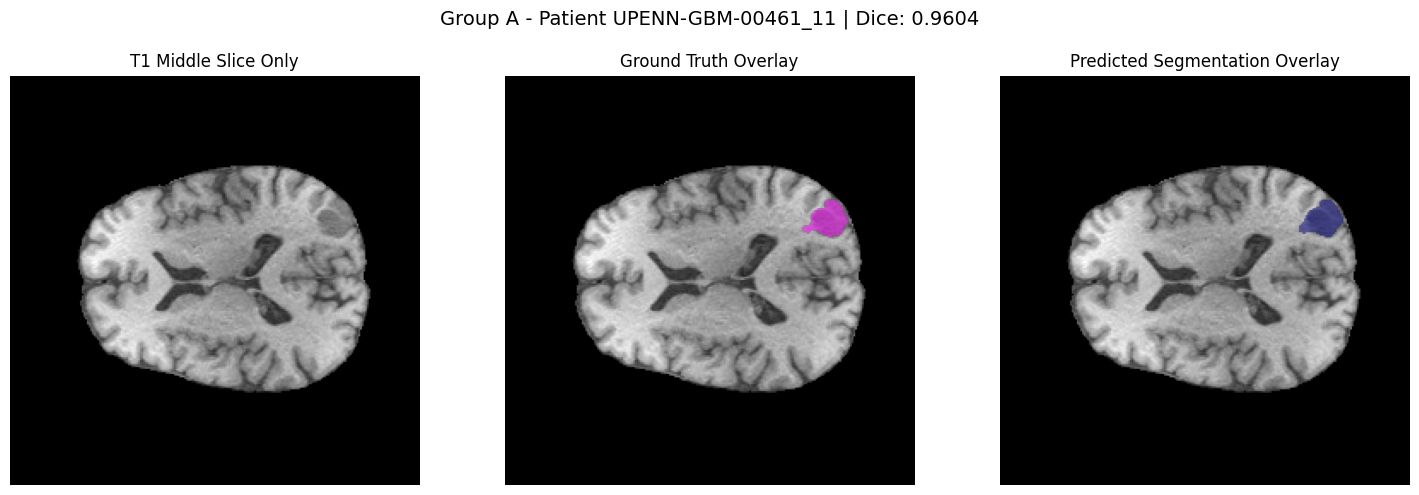

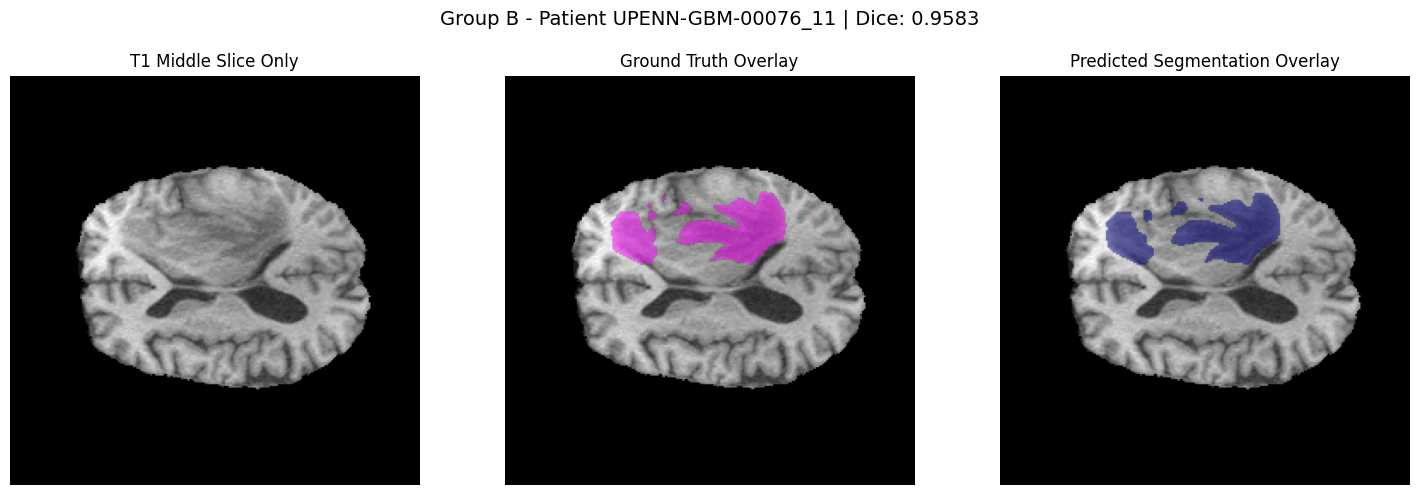

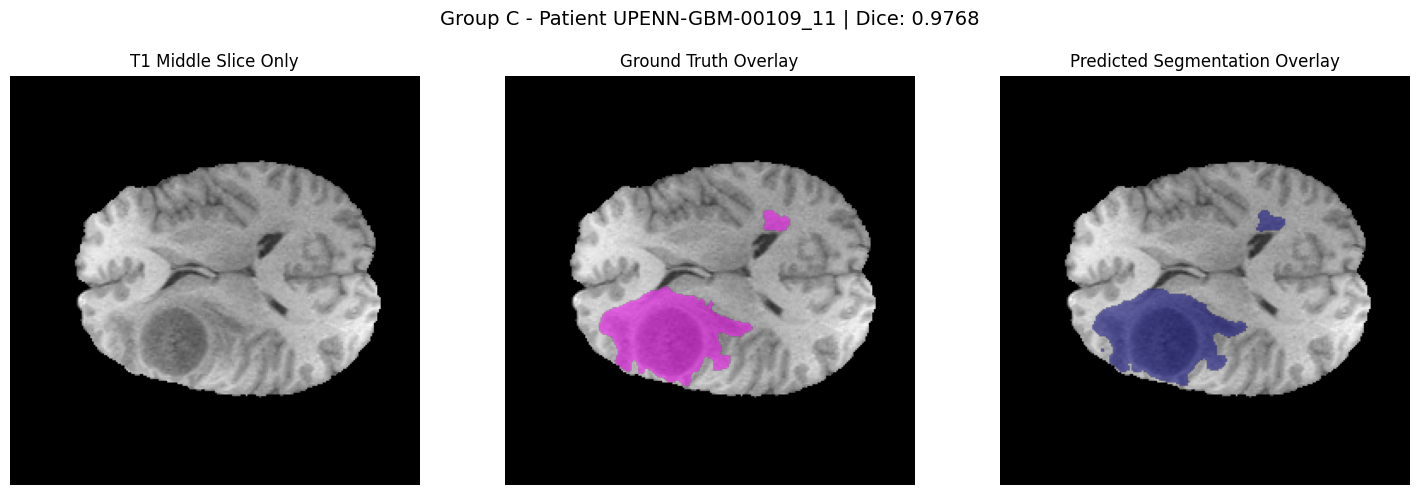

In [ ]:
import os
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Define the device 
device = torch.device("cpu")

# Dictionary of patients (one per group)
selected_patients = {
    'A': 'UPENN-GBM-00461_11',
    'B': 'UPENN-GBM-00076_11',
    'C': 'UPENN-GBM-00109_11'
}

# Paths to T1 images and segmentation masks
images_dir = "/home/ec2-user/BraTS_ML_Project/data/UPenn_GBM/images"
segs_dir   = "/home/ec2-user/BraTS_ML_Project/data/UPenn_GBM/segmentations"

for group, patient_id in selected_patients.items():
    # Construct file paths
    t1_path = os.path.join(images_dir, patient_id, f"{patient_id}_T1.nii.gz")
    seg_path = os.path.join(segs_dir, patient_id, f"{patient_id}_automated_approx_segm.nii.gz")
    
    # Load T1 volume and segmentation
    t1_nii = nib.load(t1_path)
    t1_data = t1_nii.get_fdata()  # shape [H, W, D]
    
    seg_nii = nib.load(seg_path)
    seg_data = seg_nii.get_fdata()  # shape [H, W, D]
    seg_data = np.where(seg_data > 0, 1, 0)  # binarize
    
    # Pick the middle slice
    mid_slice = t1_data.shape[2] // 2
    t1_slice = t1_data[:, :, mid_slice]
    gt_mask = seg_data[:, :, mid_slice]
    
    # Normalize T1 slice to [0,1]
    mn, mx = t1_slice.min(), t1_slice.max()
    t1_slice_norm = (t1_slice - mn) / (mx - mn + 1e-8)
    
    # Prepare input tensor: shape [1,1,H,W]
    input_tensor = torch.tensor(t1_slice_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    
    # Model inference
    model.eval()
    model = model.to(device)
    with torch.no_grad():
        output = model(input_tensor)
    pred_probs = torch.sigmoid(output).cpu().numpy()[0, 0]
    pred_mask = (pred_probs > 0.5).astype(np.uint8)
    
    # Compute Dice on the middle slice
    smooth = 1e-5
    intersection = np.sum(pred_mask * gt_mask)
    dice = (2.0 * intersection + smooth) / (np.sum(pred_mask) + np.sum(gt_mask) + smooth)
    
    # Visualization: 3 subplots in 1 row
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Group {group} - Patient {patient_id} | Dice: {dice:.4f}", fontsize=14)
    
    # Subplot 1: T1 only
    plt.subplot(1, 3, 1)
    plt.imshow(t1_slice, cmap='gray')
    plt.title("T1 Middle Slice Only")
    plt.axis('off')
    
    # Subplot 2: T1 + Ground Truth Overlay
    plt.subplot(1, 3, 2)
    plt.imshow(t1_slice, cmap='gray')
    plt.imshow(np.ma.masked_where(gt_mask == 0, gt_mask), cmap='spring', alpha=0.5)
    plt.title("Ground Truth Overlay")
    plt.axis('off')
    
    # Subplot 3: T1 + Predicted Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(t1_slice, cmap='gray')
    plt.imshow(np.ma.masked_where(pred_mask == 0, pred_mask), cmap='jet', alpha=0.5)
    plt.title("Predicted Segmentation Overlay")
    plt.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import numpy as np

# Automatically get all patient IDs from the images directory
images_dir = r"/home/ec2-user/BraTS_ML_Project/data/UPenn_GBM/images"
segs_dir   = r"/home/ec2-user/BraTS_ML_Project/data/UPenn_GBM/segmentations"

all_patient_ids = [folder for folder in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, folder))]
print("Total patients found:", len(all_patient_ids))  # Expecting 611 patients

# Define number of folds
k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Dictionary to store Dice scores for each fold
fold_dice_scores = {}

# Loop over folds
fold = 1
for train_index, val_index in kf.split(all_patient_ids):
    print(f"\nStarting Fold {fold}")
    
    # Get patient IDs for this fold
    train_ids = [all_patient_ids[i] for i in train_index]
    val_ids   = [all_patient_ids[i] for i in val_index]
    
    # Create Dataset objects for training and validation (using the 'middle' slice)
    train_dataset = T1SegmentationDataset(train_ids, images_dir, segs_dir, slice_mode='middle')
    val_dataset   = T1SegmentationDataset(val_ids, images_dir, segs_dir, slice_mode='middle')
    
    # Create DataLoaders
    batch_size = 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Instantiate a new model for this fold
    model_fold = AttentionUNet(in_channels=1, out_channels=1).to(device)
    optimizer = optim.Adam(model_fold.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_loss = float('inf')
    epochs_without_improve = 0
    num_epochs = 10  # Use a reduced number of epochs for CV to save time
    
    for epoch in range(num_epochs):
        model_fold.train()
        train_loss = 0.0
        
        for batch in train_loader:
            images = batch['image'].float().to(device)   # [B, 1, H, W]
            masks  = batch['mask'].float().to(device)      # [B, 1, H, W]
            
            optimizer.zero_grad()
            outputs = model_fold(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model_fold.eval()
        val_loss = 0.0
        dice_sum = 0.0
        num_batches = 0
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].float().to(device)
                masks  = batch['mask'].float().to(device)
                outputs = model_fold(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                
                # Compute Dice score per batch
                pred_probs = torch.sigmoid(outputs)
                pred_bin = (pred_probs > 0.5).float()
                intersection = (pred_bin * masks).sum()
                dice = (2.0 * intersection + 1e-5) / (pred_bin.sum() + masks.sum() + 1e-5)
                dice_sum += dice.item()
                
                num_batches += 1
        
        avg_val_loss = val_loss / len(val_loader)
        avg_dice = dice_sum / num_batches
        
        print(f"Fold {fold}, Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Dice: {avg_dice:.4f}")
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model_fold.state_dict()
            epochs_without_improve = 0
        else:
            epochs_without_improve += 1
        
        if epochs_without_improve >= 5:
            print("Early stopping triggered for this fold.")
            break
    
    # Save the best model state for this fold if needed:
    # torch.save(best_model_state, f"best_t1_attention_model_fold{fold}.pth")
    
    fold_dice_scores[fold] = avg_dice
    print(f"Fold {fold} Average Dice: {avg_dice:.4f}")
    fold += 1

print("\nCross-validation Dice Scores:", fold_dice_scores)
print("Mean Dice Score over all folds:", np.mean(list(fold_dice_scores.values())))

Total patients found: 611

Starting Fold 1
Fold 1, Epoch 1: Train Loss: 0.2985, Val Loss: 0.2490, Val Dice: 0.4933
Fold 1, Epoch 2: Train Loss: 0.2100, Val Loss: 0.1963, Val Dice: 0.6595
Fold 1, Epoch 3: Train Loss: 0.1682, Val Loss: 0.1805, Val Dice: 0.5969
Fold 1, Epoch 4: Train Loss: 0.1390, Val Loss: 0.1810, Val Dice: 0.5711
Fold 1, Epoch 5: Train Loss: 0.1217, Val Loss: 0.1142, Val Dice: 0.7321
Fold 1, Epoch 6: Train Loss: 0.1028, Val Loss: 0.0929, Val Dice: 0.7111
Fold 1, Epoch 7: Train Loss: 0.0893, Val Loss: 0.1063, Val Dice: 0.6649
Fold 1, Epoch 8: Train Loss: 0.0789, Val Loss: 0.0823, Val Dice: 0.5394
Fold 1, Epoch 9: Train Loss: 0.0710, Val Loss: 0.0671, Val Dice: 0.7680
Fold 1, Epoch 10: Train Loss: 0.0630, Val Loss: 0.0641, Val Dice: 0.7745
Fold 1 Average Dice: 0.7745

Starting Fold 2
Fold 2, Epoch 1: Train Loss: 0.3408, Val Loss: 0.2712, Val Dice: 0.5623
Fold 2, Epoch 2: Train Loss: 0.2319, Val Loss: 0.2055, Val Dice: 0.5826
Fold 2, Epoch 3: Train Loss: 0.1897, Val Loss: 

In [15]:
import numpy as np
import random

def random_augmentation(sample):
    """
    Randomly applies horizontal flip, vertical flip, and rotation to both the image and mask.
    
    Args:
        sample (dict): A dictionary with keys 'image', 'mask', and optionally 'patient_id'.
            - image: numpy array of shape [1, H, W]
            - mask: numpy array of shape [1, H, W]
    
    Returns:
        sample (dict): The augmented sample.
    """
    image = sample['image']
    mask = sample['mask']
    
    # Random horizontal flip (flip along the width axis, axis 2)
    if random.random() < 0.5:
        image = np.flip(image, axis=2).copy()
        mask = np.flip(mask, axis=2).copy()
    
    # Random vertical flip (flip along the height axis, axis 1)
    if random.random() < 0.5:
        image = np.flip(image, axis=1).copy()
        mask = np.flip(mask, axis=1).copy()
    
    # Random rotation (rotate by 0, 90, 180, or 270 degrees)
    rotations = random.randint(0, 3)
    if rotations:
        # np.rot90 rotates along the last two axes. Our image shape is [1, H, W]
        image = np.rot90(image, k=rotations, axes=(1, 2)).copy()
        mask = np.rot90(mask, k=rotations, axes=(1, 2)).copy()
    
    sample['image'] = image
    sample['mask'] = mask
    return sample

In [ ]:
# For the training set, add the augmentation transform:
train_dataset = T1SegmentationDataset(train_ids, images_dir, segs_dir, slice_mode='middle', transform=random_augmentation)

# For validation and testing, we typically do not apply augmentation:
val_dataset   = T1SegmentationDataset(val_ids, images_dir, segs_dir, slice_mode='middle')
test_dataset  = T1SegmentationDataset(test_ids, images_dir, segs_dir, slice_mode='middle')

# Create DataLoaders (as before)
from torch.utils.data import DataLoader
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Patient: UPENN-GBM-00001_11 - Sum of mask pixels: 0.0


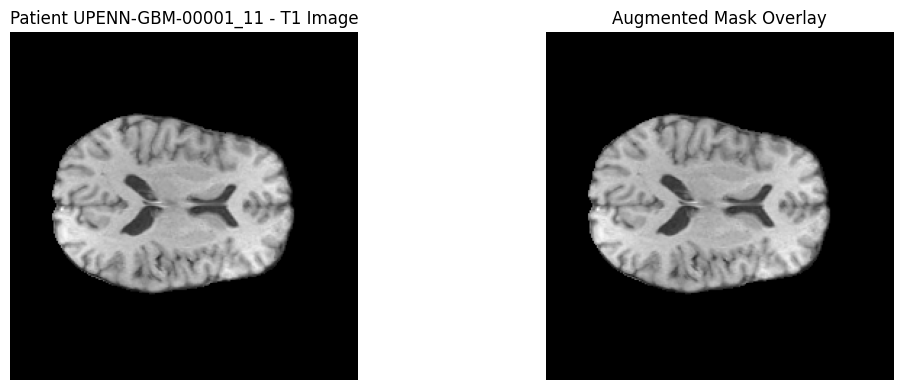

Patient: UPENN-GBM-00003_11 - Sum of mask pixels: 0.0


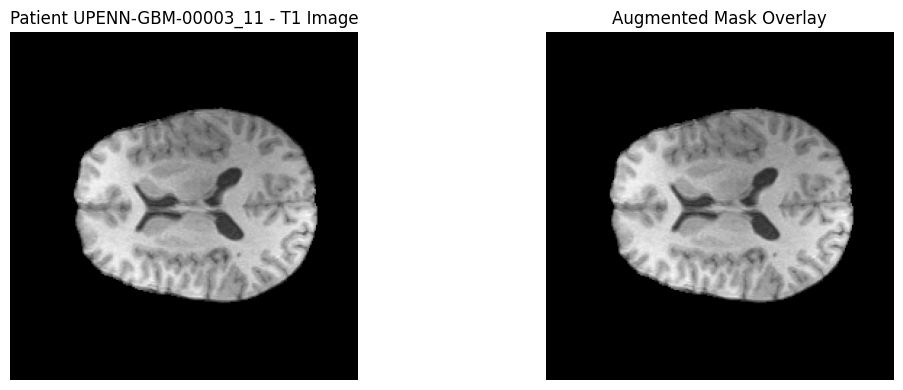

Patient: UPENN-GBM-00004_11 - Sum of mask pixels: 1692.0


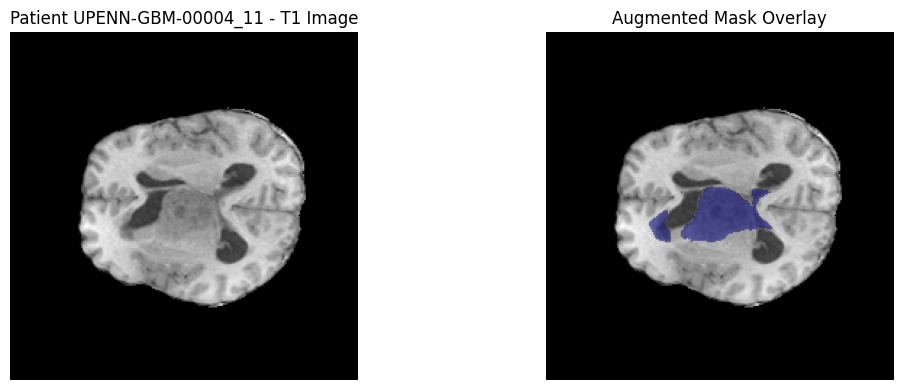

Patient: UPENN-GBM-00006_11 - Sum of mask pixels: 658.0


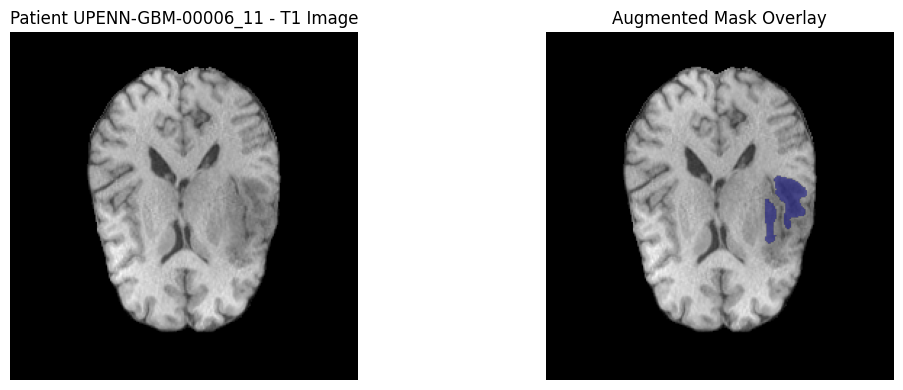

Patient: UPENN-GBM-00007_11 - Sum of mask pixels: 2045.0


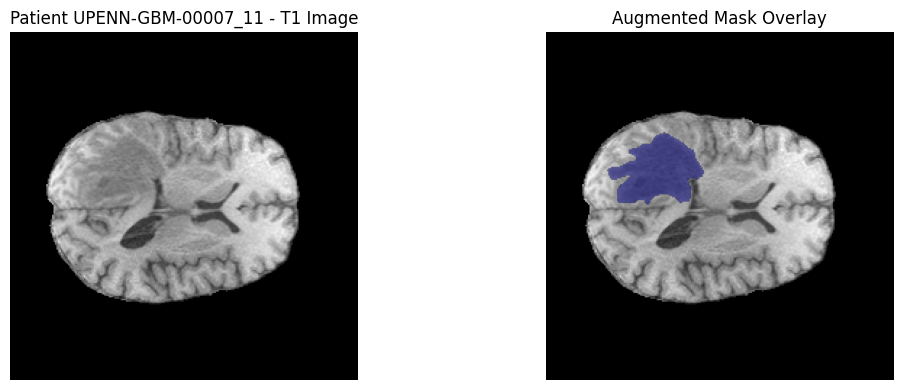

In [ ]:
import matplotlib.pyplot as plt

# Number of samples to display 
num_samples_to_display = 5

for i in range(num_samples_to_display):
    # Get the i-th sample from training dataset (which applies augmentation)
    sample = train_dataset[i]
    
    # Extract the T1 image and mask from the sample.
    # Note: The image and mask shape is [1, H, W] so we take the first channel.
    image = sample['image'][0]  # shape: [H, W]
    mask = sample['mask'][0]    # shape: [H, W]
    
    # Print the patient ID and the sum of the mask (number of tumour pixels), which can give a numeric check.
    print(f"Patient: {sample['patient_id']} - Sum of mask pixels: {np.sum(mask)}")
    
    # Create a side-by-side visualization.
    plt.figure(figsize=(12, 4))
    
    # Left panel: T1 image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Patient {sample['patient_id']} - T1 Image")
    plt.axis('off')
    
    # Right panel: Augmented Mask
    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    # Use np.ma.masked_where to overlay the mask in color (use a colormap like 'jet' for contrast)
    plt.imshow(np.ma.masked_where(mask == 0, mask), cmap='jet', alpha=0.5)
    plt.title("Augmented Mask Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Evaluate on Test Set
# This cell loads the best T1 Attention U-Net model, runs inference on the test set,
# and computes both the average BCE loss and an average Dice score.

import torch
import torch.nn as nn
import numpy as np

def dice_coefficient(pred, target, smooth=1e-5):
    """
    Computes the Dice score for binary segmentation using PyTorch tensors.
    pred: model outputs (logits) with shape [B, 1, H, W]
    target: ground truth masks with shape [B, 1, H, W]
    smooth: small constant to avoid division by zero
    """
    # Convert logits to probabilities
    pred_probs = torch.sigmoid(pred)
    
    # Binarize predictions at 0.5
    pred_bin = (pred_probs > 0.5).float()
    
    intersection = (pred_bin * target).sum()
    dice = (2.0 * intersection + smooth) / (pred_bin.sum() + target.sum() + smooth)
    return dice

# Path to best model
model_path = "/home/ec2-user/BraTS_ML_Project/models/best_t1_attention_model.pth"

# Re-instantiate the same architecture
model_test = AttentionUNet(in_channels=1, out_channels=1).to(device)
model_test.load_state_dict(torch.load(model_path, map_location=device))
model_test.eval()

test_loss = 0.0
test_dice = 0.0
num_batches = 0

criterion = nn.BCEWithLogitsLoss()

with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].float().to(device)  # [B, 1, H, W]
        masks  = batch['mask'].float().to(device)   # [B, 1, H, W]
        
        outputs = model_test(images)
        
        # 1) Compute BCE loss
        loss = criterion(outputs, masks)
        test_loss += loss.item()
        
        # 2) Compute Dice score
        dice_score = dice_coefficient(outputs, masks)
        test_dice += dice_score.item()
        
        num_batches += 1

avg_test_loss = test_loss / num_batches
avg_test_dice = test_dice / num_batches

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Dice: {avg_test_dice:.4f}")

Test Loss: 0.0269
Test Dice: 0.8136


In [ ]:
import torch
# Switch model to evaluation mode
model.eval()
# Create an example input in the shape model expects: [1, 1, H, W]
# For T1 images, in_channels=1. Just pick a sample shape, e.g., [1,1,240,240] if that's typical.
example_input = torch.randn(1, 1, 240, 240, dtype=torch.float32).to(device)
# Trace the model to create a TorchScript version
traced_model = torch.jit.trace(model, example_input)
# Define a path to save TorchScript model
save_path = "/home/ec2-user/BraTS_ML_Project/models/t1_attention_model_script.pt"
# Save the scripted model
torch.jit.save(traced_model, save_path)
print(f"Augmented T1-only Attention U-Net saved as TorchScript at: {save_path}")

Augmented T1-only Attention U-Net saved as TorchScript at: /home/ec2-user/BraTS_ML_Project/models/t1_attention_model_script.pt
